## Titanic Kaggle Competition <a class="anchor" id="first-bullet"></a>
### Exploratory Data Analysis
Our focus here is to:
- Gain intuition about the data
- Make sure that insights we're drawing are actually from the right dataset
- Find out where data is missing
- Check for outliers
- Summarize the data

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (15, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78", "#ED8936", "#9F7AEA", "#ECC94B"])
rcParams["figure.facecolor"] = "#1A202C"
rcParams["axes.facecolor"] = "#2D3748"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import t as tDist
from scipy.stats import spearmanr as spearman
from scipy.stats import chi2_contingency as chisquare

train = pd.read_pickle("titanic-train.pkl")

def UVANumeric(df, column):
    col = df[column].dropna()
    minVal = col.min()
    maxVal = col.max()
    rangeVal = maxVal - minVal
    mean = col.mean()
    median = col.median()
    std = col.std()
    stdLow = mean - std
    stdHigh = mean + std
    skew = col.skew()
    # Kurtosis is the 4th central moment over squared variance - 3
    # for identifying whether the tails contain extreme values
    kurtosis = col.kurtosis()
    
    sns.kdeplot(col, shade=True, label=column)
    sns.lineplot(x=[stdLow, stdHigh], y=[0, 0], color="orange", linewidth=5, label="std dev")
    sns.scatterplot(x=[minVal, maxVal], y=[0, 0], color="red", s=200, label="min/max")
    sns.scatterplot(x=[mean], y=[0], color="green", s=200, label="mean")
    sns.scatterplot(x=[mean], y=[0], color="purple", s=200, label="median")
    plt.xlabel(column)
    plt.title("{} Univariate Analysis".format(column))
    
    figtext = "Min: {} | Max: {} | Range: {} | Mean: {} | Median: {}\nStd: {} | StdLow: {} | StdHigh: {} | Skew: {} | Kurtosis: {}"
    figtext = figtext.format(round(minVal, 2), round(maxVal, 2), round(rangeVal, 2), round(mean, 2), round(median, 2), round(std, 2), round(stdLow, 2), round(stdHigh, 2), round(skew, 2), round(kurtosis, 2))
    plt.figtext(0.5, -0.05, figtext, **{"fontsize": 20, "color": "#A0AEC0", "horizontalalignment": "center"})
    
def UVACategory(df, column, vertical=False):
    col = df[column].dropna()
    count = col.value_counts()
    maxVal = max(count)
    indexes = count.index.tolist()
    normedCount = col.value_counts(normalize=True)
    uniqueCount = col.nunique()
    
    rotation = 90 if vertical else 0
    
    plot = sns.countplot(x=col, order=indexes)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=rotation)
    i = 0
    for p in plot.patches:
        height = p.get_height()
        width = p.get_width()
        
        iNormedCount = round(normedCount[indexes[i]], 2)
        iNormedCount = round(normedCount[indexes[i]], 4) if iNormedCount == 0 else iNormedCount
        isShort = (height / maxVal) < 0.1
        xPos = p.get_x() + width / 2.0
        yPos = height if isShort else height / 2.0
        va = "bottom" if isShort else "center"
        
        text = "{}\n{}".format(round(count[indexes[i]], 2), iNormedCount)
        plot.text(xPos, yPos, text, ha="center", va=va, rotation=rotation, size=12)
        i += 1
    plt.title("{} Univariate Analysis\nUnique: {} values".format(column, uniqueCount))

# Uses Spearman Correlation
def BVANumericNumeric(df, column1, column2):
    # Scatter Plot
    col1 = df[column1]
    col2 = df[column2]
    
    sns.regplot(x=col1, y=col2)
    plt.title("{} vs. {}".format(column1, column2))
    corr, pVal = spearman(a=col1, b=col2, nan_policy="omit")
    figtext = "Spearman Correlation Coefficient: {}\nCorrelation P-Value: {}".format(round(corr, 4), round(pVal, 4))
    plt.figtext(0.5, -0.05, figtext, **{"fontsize": 20, "color": "#A0AEC0", "horizontalalignment": "center"})
    
# Uses T-Test
def BVACategoryNumeric(df, catCol, numCol):
    sns.catplot(x=catCol, y=numCol, data=df, kind="violin")
    plt.title("{} vs. {}".format(catCol, numCol))
    
    unique = df[catCol].unique()
    if len(unique) == 2:
        # We can do the T-Test
        col1 = df[numCol][df[catCol] == unique[0]]
        col2 = df[numCol][df[catCol] == unique[1]]
        
        tTestPVal = IndependentTwoSampleTTest(col1, col2)
        figtext = "T-Test P-Value: {}\nDifference in Means: {}".format(round(tTestPVal, 4), round(abs(col1.mean() - col2.mean()), 4))
        plt.figtext(0.5, -0.13, figtext, **{"fontsize": 20, "color": "#A0AEC0", "horizontalalignment": "center"})
    
# Uses Chi-Test
def BVACategoryCategory(df, column1, column2):
    col1 = df[column1]
    col2 = df[column2]
    
    obs = pd.crosstab(col1, col2, margins=True)
    sns.barplot(x=col1, y=col2)
    plt.title("{} vs. {}".format(column1, column2))
    chiSqr, pVal, dof, exp = chisquare(obs)
    cramerV = np.sqrt(chiSqr / (len(col1) * (min(len(col1), 2) - 1))) # Since we are only dealing with 2 cols/variables, the min would almost always be 2, and -1 will just be 1
    
    figtext = "Cramer's V: {}\nP-Value: {}".format(round(cramerV, 4), round(pVal, 4))
    plt.figtext(0.5, -0.05, figtext, **{"fontsize": 20, "color": "#A0AEC0", "horizontalalignment": "center"})
    
# Tests whether there is a significant difference in means between the numerical values as separated by the 2 categorical values 
# (ex. the mean of the ages of those that survived vs ages of those that didn't survive)
# For figuring out if the apparent difference between groups happened by chance or not
# For independent groups
def IndependentTwoSampleTTest(group1, group2):
    n1 = len(group1)
    n2 = len(group2)
    mean1 = group1.mean()
    mean2 = group2.mean()
    std1 = group1.std()
    std2 = group2.std()
    
    tVal = (mean1 - mean2) / np.sqrt(std1**2 / n1 + std2**2 / n2)
    df = n1 + n2 - 2 # degrees of freedom
    pVal = 2 * (1 - tDist.cdf(abs(tVal), df)) # two-sided test
    return pVal

#### Draw out important insights
1. Variables
    - Pclass
        - Ticket class, used as a proxy for socio-economic status
        - Categorical (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
    - Sex
        - Categorical (male or female)
    - Age
        - Numerical (min = 0.42, max = 80)
    - SibSp
        - num of siblings / spouses aboard the Titanic
        - Numerical (min = 0, max = 8)
    - Parch
        - num of parents / children aboard the Titanic
        - Numerical (min = 0, max = 6)
    - Fare
        - Passenger fare
        - Numerical (min = 0, max = 512.3292)
    - Embarked
        - Which port the passenger embarked from
        - Categorical (C = Cherbourg, Q = Queenstown, S = Southampton)
    - Survived
        - **Output variable**
        - Categorical (0 = Didn't survive, 1 = Survived)
2. Univariate Analysis

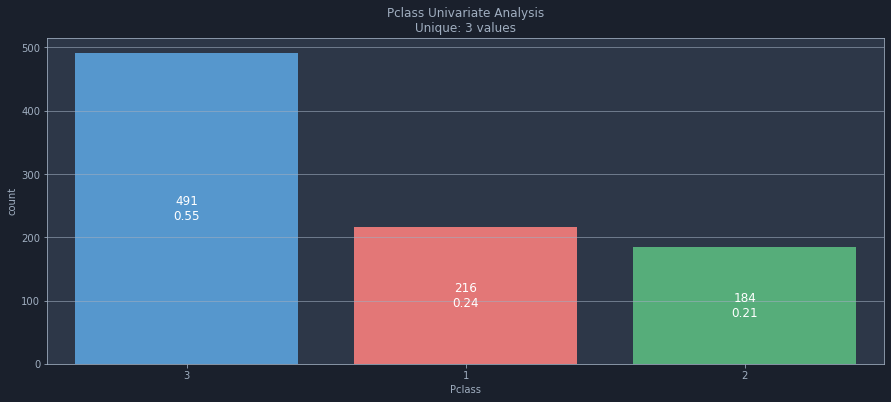

In [3]:
UVACategory(train, "Pclass")

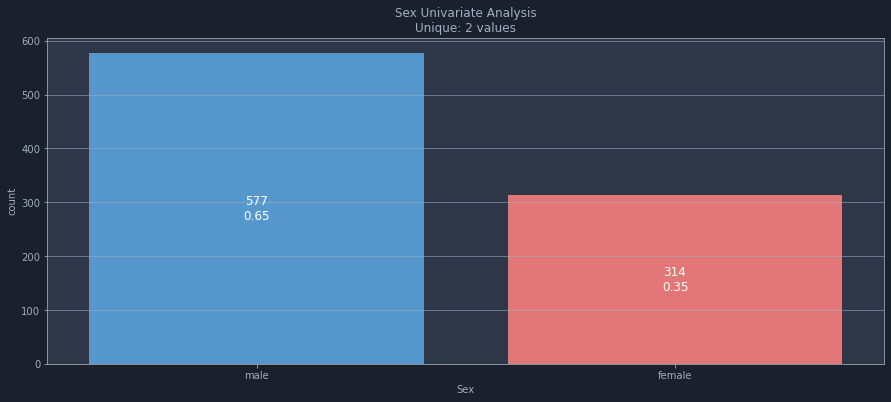

In [4]:
UVACategory(train, "Sex")

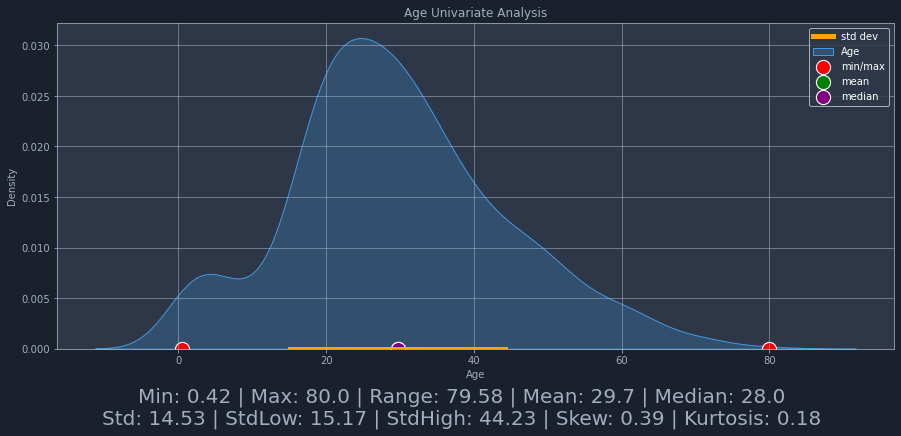

In [5]:
UVANumeric(train, "Age")

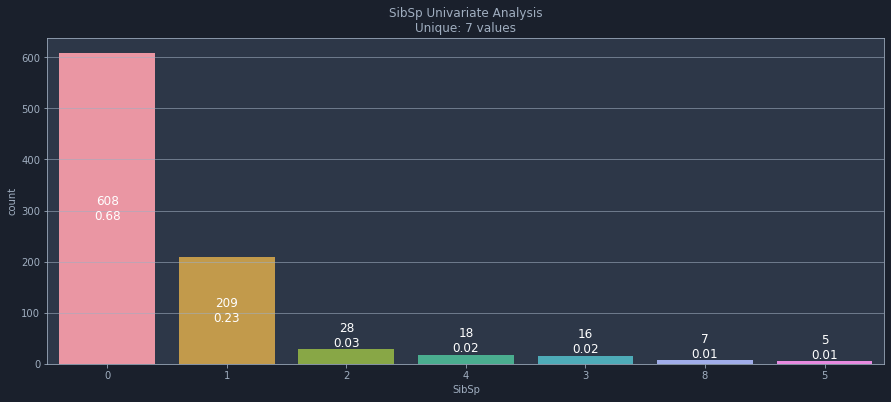

In [6]:
UVACategory(train, "SibSp")

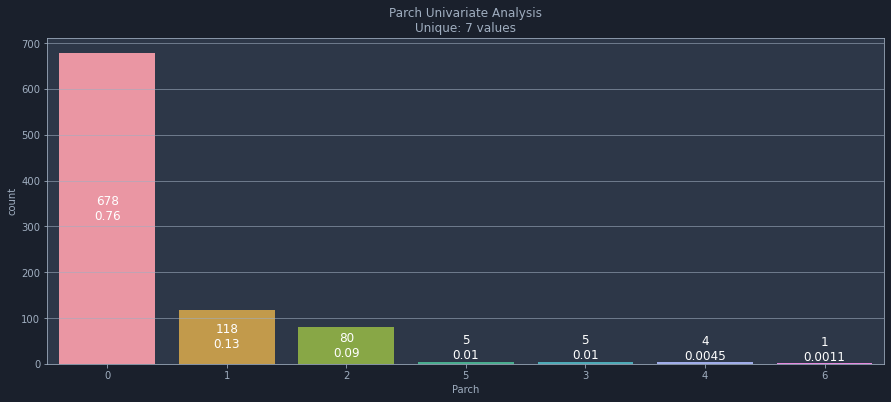

In [7]:
UVACategory(train, "Parch")

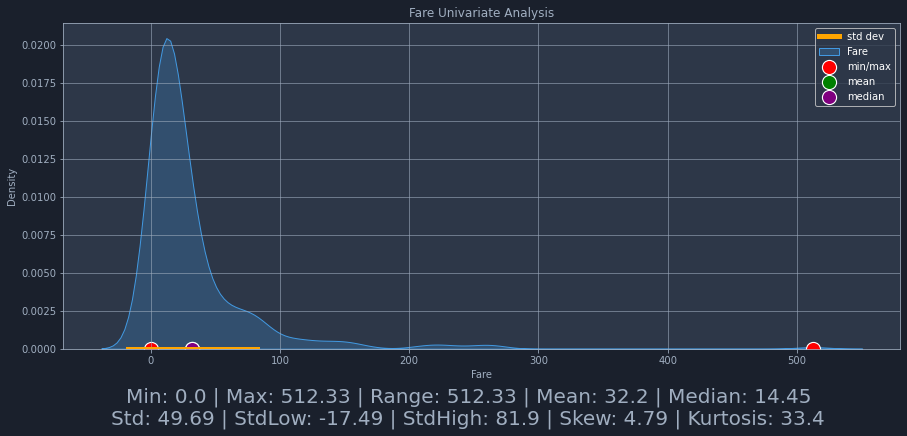

In [8]:
UVANumeric(train, "Fare")

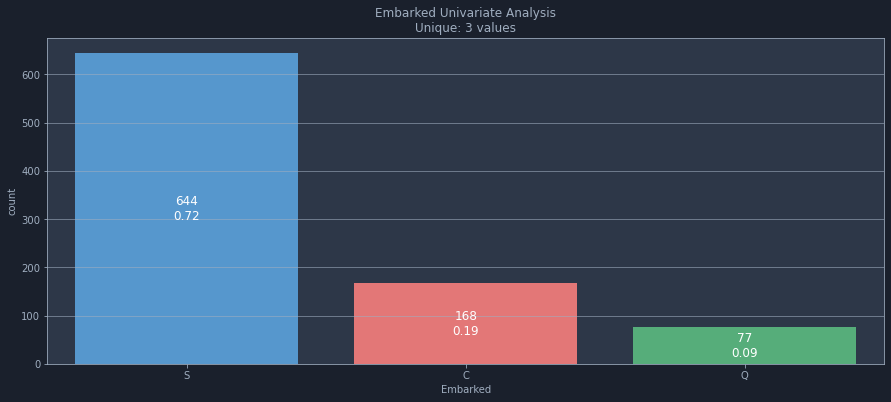

In [9]:
UVACategory(train, "Embarked")

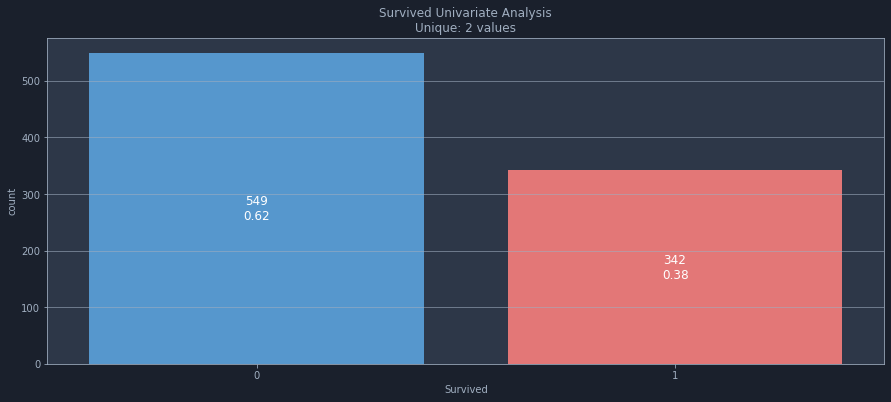

In [10]:
UVACategory(train, "Survived")

3. Bivariate Analysis
    - See the relationship between inputs and outputs (in this case, one output, "Survived")

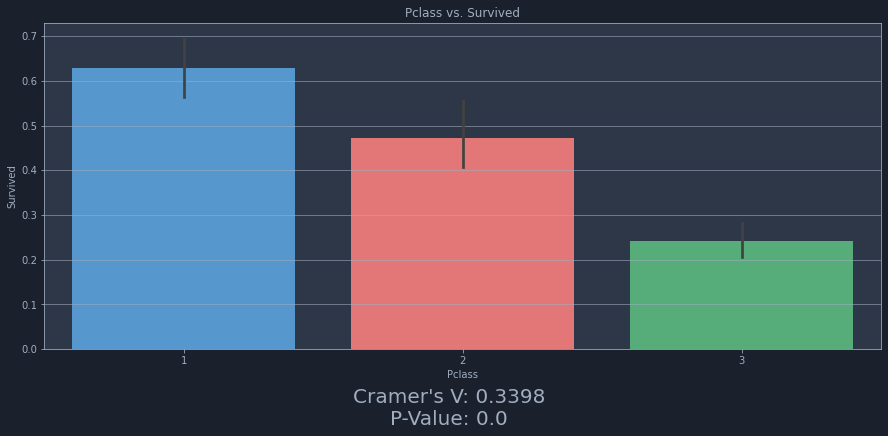

In [11]:
BVACategoryCategory(train, "Pclass", "Survived")

Based on this graph, people with higher class tickets (or of higher class) is more likely to survive than those with lower class tickets.

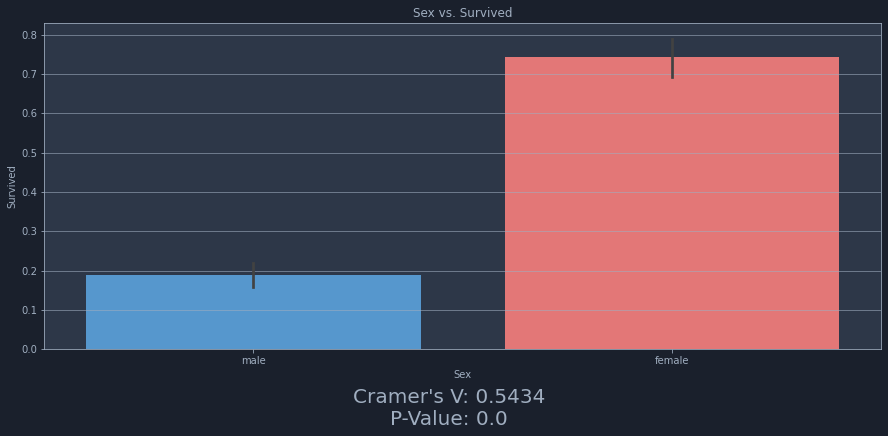

In [12]:
BVACategoryCategory(train, "Sex", "Survived")

Based on this graph, women are more likely to survive than men.

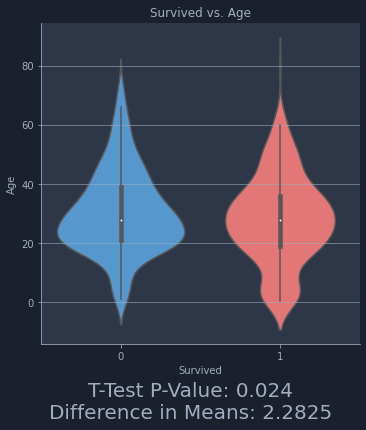

In [13]:
BVACategoryNumeric(train, "Survived", "Age")

Based on this graph, age didn't seem to matter much for survival, although most people over 70 seemed to have died.

Furthermore, given the T-Test P-Value of 0.024, which is less than 0.05, the difference between the means of the two groups is statistically significant/didn't happen by chance (aka. we can reject the null hypothesis of equal means between these two groups).

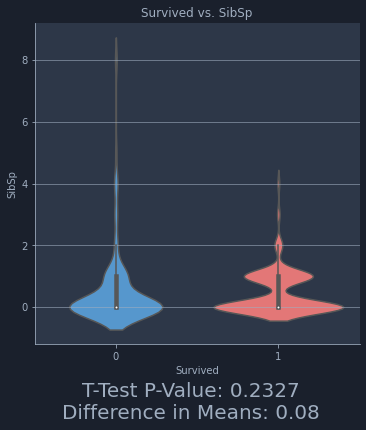

In [14]:
BVACategoryNumeric(train, "Survived", "SibSp")

Based on this graph, the number of siblings/spouses aboard the Titanic didn't seem to matter much for survival.

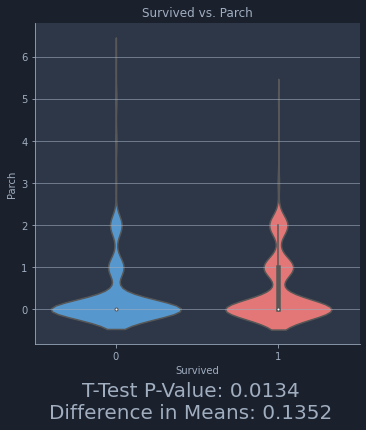

In [15]:
BVACategoryNumeric(train, "Survived", "Parch")

Based on this graph, the number of parents/children aboard the Titanic didn't seem to matter much for survival.

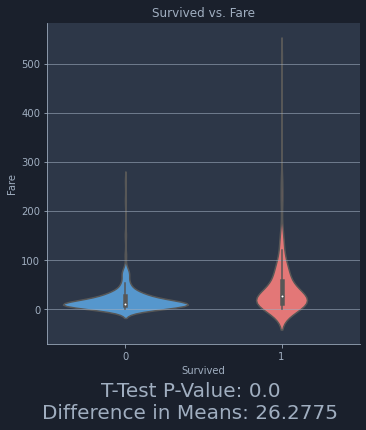

In [16]:
BVACategoryNumeric(train, "Survived", "Fare")

Based on this graph, the amount of fare paid didn't seem to matter much, although people that paid above $100 were a bit more likely to survive.

However, based on the T-Test P-Value of 0, which is less than 0.05, the difference between the means of the two groups is statistically significant.

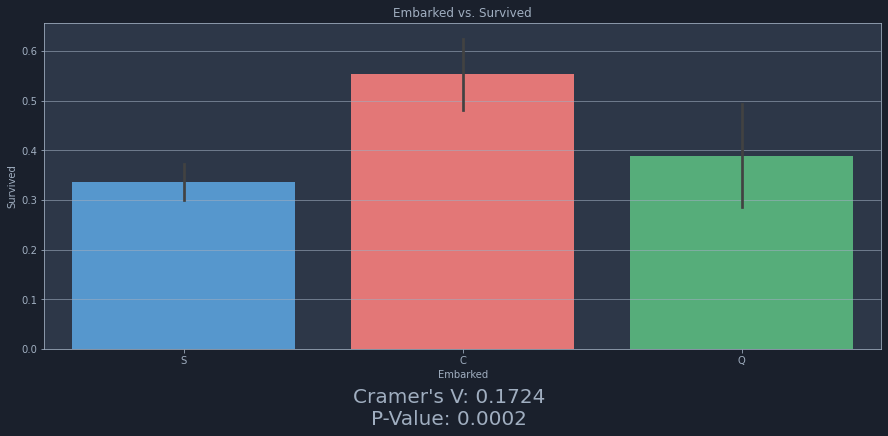

In [17]:
BVACategoryCategory(train, "Embarked", "Survived")

Based on this graph, there were more people from Cherbourg that survived, even though they only account for 19% of the total population aboard the Titanic.